# PREDICTING HOUSE SALE PRICES - LINEAR REGRESSION

The ameshousing dataset contains information on all the residential properties that were sold between 2006 to 2010 in the city of Ames, Iowa, United States.

The information contains the features and characteritics of the residential properties in the city. 
These features will be used to create, train and test a linear regression model that will predict the sale prices of the properties.

In particular there will be a focus on the preparation of the data in the following areas:

* Feature Transformation
* Feature Selection

There are a variety of different variables in the dataset that will need to be prepared and modified so that they are suitable for input into a linear regression model.

The dataset includes:

* 20 continuous variables related to the various dimensions of the houses.
* 14 discrete variables, typically quantifying the number of items occuring within the house.
* 23 nominal and 23 ordinal categorical variables that describe other features and rate the various features of the houses.

The project is broken in to three parts:

* Feature Transformation
* Feature Selection
* Test and Training

The feature transformation part will be implemented in a function that takes in the ameshousing dataset and returns a dataset, with features that are suitable as input in the linear regression model.
 
This modified dataset that is returned will then be passed to a feature selection function that will return a dataset with only selected features.
 
The dataset retuned by the feature selection function will be passed to a final function that will train and test a linear regression model/models and will return the root mean squared error of the model.

The objective is to prepare and select features as to minimise the root mean squared error of the linear regression model and make accurate predictions.

Import libraries and read the dataset into data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, cross_val_score

ames = pd.read_csv('AmesHousing.tsv', sep='\t')

In [2]:
ames.shape

(2930, 82)

## FUNCTIONS

To make modifying and testing the dataset easy, three functions have been created that will encapsulate each part of the project.

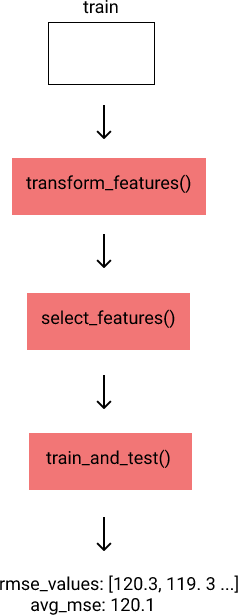

A linear regression model has been created using only the numeircal columns from the ameshousing dataset.

* Initially only one feature, 'Gr Liv Area', is used to predict house prices.

In [3]:
def transform_features(df):
    return df

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    
    # split the dataset into a train and test datasets
    train = df.iloc[0:1460, :]
    test = df.iloc[1460:, :]
    
    # get datasets from train and test containing only numeric columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    # get list of all the column names that will be used as features
    features = numeric_train.columns.drop('SalePrice')
    
    linear = LinearRegression()
    linear.fit(X = train[features], y = train['SalePrice'])
    predictions = linear.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

In [4]:
transform_df = transform_features(ames)
select_df = select_features(transform_df)
rmse = train_and_test(select_df)
rmse

57088.25161263909

Our first model with no data preparation has a root mean squared error (rmse) of \\$57088.25.

## FEATURE ENGINEERING

Now the dataset will be cleaned and modified to pass better input data into the linear regression model.
All the steps will be done on a copy of the dataset and then encapsulated in the transform_features function.

### MISSING VALUES

I will start off with a 5% threshold for all columns.
    * Any columns with 5% or more missing values will be dropped.

For any remaining text based columns:
    * If one value is missing the column will be dropped.
    
For the remaining numeric columns:
    * Any columns with missing data, fill in with the most common value in that column.

1. Drop all columns with 5% or more missing values.

In [5]:
data_missing = ames.isnull().sum()
drop = data_missing[data_missing > ames.shape[0] / 20]
drop

Lot Frontage      490
Alley            2732
Fireplace Qu     1422
Garage Type       157
Garage Yr Blt     159
Garage Finish     159
Garage Qual       159
Garage Cond       159
Pool QC          2917
Fence            2358
Misc Feature     2824
dtype: int64

The 11 columns above have more than 5% of their values missing and therefore will be dropped from the dataframe.

In [6]:
cols_drop = drop.index
data = ames.drop(cols_drop, axis = 1)
data.shape

(2930, 71)

2. Drop any text columns with 1 or more missing values.

In [7]:
text_drop = data.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
text_drop[text_drop > 0]

Bsmt Exposure     83
BsmtFin Type 2    81
BsmtFin Type 1    80
Bsmt Qual         80
Bsmt Cond         80
Mas Vnr Type      23
Electrical         1
dtype: int64

We can see that there are 7 text columns with missing values, all of these will be dropped.

In [8]:
t_cols = text_drop[text_drop > 0].index
data = data.drop(t_cols, axis=1)
data.shape

(2930, 64)

3. For the any remaining numeric columns, missing values will be replaced with the mode of the respective columns.

In [9]:
numeric_missing = data.select_dtypes(include=['integer', 'float']).isnull().sum().sort_values(ascending=False)
numeric_missing[numeric_missing > 0]

Mas Vnr Area      23
Bsmt Half Bath     2
Bsmt Full Bath     2
Garage Cars        1
BsmtFin SF 1       1
Total Bsmt SF      1
Bsmt Unf SF        1
BsmtFin SF 2       1
Garage Area        1
dtype: int64

In [10]:
num_col = list(numeric_missing[numeric_missing > 0].index)
replace = {}
for col in num_col:
    replace[col] = data[col].mode()[0]
replace

{'Mas Vnr Area': 0.0,
 'Bsmt Half Bath': 0.0,
 'Bsmt Full Bath': 0.0,
 'Garage Cars': 2.0,
 'BsmtFin SF 1': 0.0,
 'Total Bsmt SF': 0.0,
 'Bsmt Unf SF': 0.0,
 'BsmtFin SF 2': 0.0,
 'Garage Area': 0.0}

Replace the missing numeric values and check that there are no missing values in the dataframe.

In [11]:
data.fillna(replace, inplace=True)
data.isnull().sum().value_counts()

0    64
dtype: int64

### CREATING NEW FEATURES

A brief look at the columns remaining:

In [12]:
#data.info()

After looking through the documentation there are a few columns that are of no use in their current format. These columns all contain dates:

* Year Built
* Year Remod/Add

A more useful metric is the number of years before the house was sold and the number of years since the house has been remodelled.

In [13]:
years_before_sale = data['Yr Sold'] - data['Year Built']
years_since_remod = data['Yr Sold'] - data['Year Remod/Add']

In [14]:
print(years_before_sale[years_before_sale < 0])
print(years_since_remod[years_since_remod < 0])

2180   -1
dtype: int64
1702   -1
2180   -2
2181   -1
dtype: int64


In [15]:
data['Years Before Sale'] = years_before_sale
data['Years Since Remod'] = years_since_remod

# remove rows with negative values
data.drop([1702, 2180, 2181], axis=0, inplace=True)

# drop the two original columns
data.drop(['Year Built', 'Year Remod/Add'], axis = 1, inplace=True)

### DATA LEAKAGE

Any columns that contain values that would not be available on new untested data and would leak information about the target column, SalePrice will be dropped.
Additonally there are a few columns that are of no use to this model, these will be dropped aswell.

In [16]:
# columns that leak data
data = data.drop(['Yr Sold', 'Mo Sold', 'Sale Type', 'Sale Condition'], axis = 1)

# columns of no use
data = data.drop(['PID', 'Order'], axis=1)

### UPDATE TRANSFORM FEATURES FUNCTION 

All the changes made to the features above will be put in the transfrom_features function. The model will be tested to see if there is an imporvement/reuction in the rmse value still using only the 'Gr Liv Area' column.

In [17]:
def transform_features(df):
    
    # missing values
    data_missing = df.isnull().sum()
    drop = data_missing[data_missing > ames.shape[0] / 20].index
    data = ames.drop(drop, axis = 1)
    
    text_drop = data.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    t_cols = text_drop[text_drop > 0].index
    data = data.drop(t_cols, axis=1)
    
    numeric_missing = data.select_dtypes(include=['integer', 'float']).isnull().sum().sort_values(ascending=False)
    num_col = list(numeric_missing[numeric_missing > 0].index)
    replace = {}
    for col in num_col:
        replace[col] = data[col].mode()[0]
    data = data.fillna(replace)
    
    # creating new features
    years_before_sale = data['Yr Sold'] - data['Year Built']
    years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    data['Years Before Sale'] = years_before_sale
    data['Years Since Remod'] = years_since_remod
    data = data.drop([1702, 2180, 2181], axis=0)
    data = data.drop(['Year Built', 'Year Remod/Add'], axis = 1)
    
    # data leakage
    data = data.drop(['Yr Sold', 'Mo Sold', 'Sale Type', 'Sale Condition'], axis = 1)
    data = data.drop(['PID', 'Order'], axis=1)
    
    return data

def select_features(df):
    return df[['Gr Liv Area', 'SalePrice']]

def train_and_test(df):
    
    # split the dataset into a train and test datasets
    train = df.iloc[0:1460, :]
    test = df.iloc[1460:, :]
    
    # get datasets from train and test containing only numeric columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    # get list of all the column names that will be used as features
    features = numeric_train.columns.drop('SalePrice')
    
    linear = LinearRegression()
    linear.fit(X = train[features], y = train['SalePrice'])
    predictions = linear.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

In [18]:
transform_df = transform_features(ames)
select_df = select_features(transform_df)
rmse = train_and_test(select_df)
rmse

55275.367312413066

After doing a bit of feature engineering and data cleaning our linear regression model's rmse error has reduced from \\$57088.25 to \\$55275.37.

This is an imporvment albeit slight using only one feature. In the next section, more numerical features will be selected based on correlation with the target variable and categorical variables will be prepared to be used in the model.

## FEATURE SELECTION

### CORRELATION BETWEEN FEATURES AND TARGET VARIABLE

We only want to keep features that have a strong correlation (whether positive or negative) with the target column. Features that do not have a strong correlation do not provide any information or predicting power to the model.

First I will find the correlation between all the numeric columns in the dataframe and the target variable.

In [19]:
numeric_corr = transform_df.select_dtypes(include=['integer', 'float']).corr()
numeric_corr

,MS SubClass,Lot Area,Overall Qual,Overall Cond,Mas Vnr Area,BsmtFin SF 1,BsmtFin SF 2,Bsmt Unf SF,Total Bsmt SF,1st Flr SF,...,Wood Deck SF,Open Porch SF,Enclosed Porch,3Ssn Porch,Screen Porch,Pool Area,Misc Val,SalePrice,Years Before Sale,Years Since Remod
MS SubClass,1.000000,-0.204638,0.040285,-0.067498,0.005502,-0.058276,-0.070936,-0.129873,-0.219990,-0.250497,...,-0.016283,-0.013309,-0.022963,-0.037988,-0.050696,-0.003451,-0.024356,-0.085128,-0.037655,-0.044886
Lot Area,-0.204638,1.000000,0.090426,-0.033487,0.114982,0.180192,0.084454,0.020899,0.241353,0.321311,...,0.152849,0.089202,0.023004,0.016619,0.056135,0.094421,0.038013,0.267520,-0.020882,-0.019848
Overall Qual,0.040285,0.090426,1.000000,-0.093907,0.418972,0.278274,-0.040551,0.268760,0.545792,0.474888,...,0.253120,0.290553,-0.139907,0.018537,0.042412,0.030638,-0.027685,0.801206,-0.596358,-0.570231
Overall Cond,-0.067498,-0.033487,-0.093907,1.000000,-0.132071,-0.050143,0.040846,-0.136758,-0.174840,-0.157746,...,0.021046,-0.067152,0.071287,0.043804,0.043915,-0.016822,0.047066,-0.101540,0.369267,-0.046373
Mas Vnr Area,0.005502,0.114982,0.418972,-0.132071,1.000000,0.284305,-0.014139,0.087535,0.378545,0.376205,...,0.158743,0.123395,-0.109775,0.014689,0.068366,0.005143,-0.022884,0.506983,-0.306163,-0.190821
BsmtFin SF 1,-0.058276,0.180192,0.278274,-0.050143,0.284305,1.000000,-0.053656,-0.487829,0.522775,0.439662,...,0.216577,0.105248,-0.100343,0.051644,0.098336,0.085531,0.015748,0.439284,-0.278070,-0.148456
BsmtFin SF 2,-0.070936,0.084454,-0.040551,0.040846,-0.014139,-0.053656,1.000000,-0.238304,0.093368,0.088282,...,0.099212,-0.003918,0.032310,-0.023347,0.062897,0.044386,-0.002650,0.006127,0.027250,0.062075
Bsmt Unf SF,-0.129873,0.020899,0.268760,-0.136758,0.087535,-0.487829,-0.238304,1.000000,0.414595,0.296824,...,-0.040532,0.113352,0.006913,-0.005256,-0.047593,-0.031912,-0.026767,0.182751,-0.129199,-0.166312
Total Bsmt SF,-0.219990,0.241353,0.545792,-0.174840,0.378545,0.522775,0.093368,0.414595,1.000000,0.792227,...,0.222595,0.222762,-0.084576,0.039180,0.078435,0.073808,-0.011832,0.644012,-0.409209,-0.298629
1st Flr SF,-0.250497,0.321311,0.474888,-0.157746,0.376205,0.439662,0.088282,0.296824,0.792227,1.000000,...,0.218907,0.212943,-0.065170,0.045636,0.102147,0.124920,-0.011628,0.635185,-0.310902,-0.241824


In [20]:
target_corr = numeric_corr["SalePrice"].abs().sort_values(ascending=False)
target_corr

SalePrice            1.000000
Overall Qual         0.801206
Gr Liv Area          0.717596
Garage Cars          0.648361
Total Bsmt SF        0.644012
Garage Area          0.641425
1st Flr SF           0.635185
Years Before Sale    0.558979
Full Bath            0.546118
Years Since Remod    0.534985
Mas Vnr Area         0.506983
TotRms AbvGrd        0.498574
Fireplaces           0.474831
BsmtFin SF 1         0.439284
Wood Deck SF         0.328183
Open Porch SF        0.316262
Half Bath            0.284871
Bsmt Full Bath       0.276258
2nd Flr SF           0.269601
Lot Area             0.267520
Bsmt Unf SF          0.182751
Bedroom AbvGr        0.143916
Enclosed Porch       0.128685
Kitchen AbvGr        0.119760
Screen Porch         0.112280
Overall Cond         0.101540
MS SubClass          0.085128
Pool Area            0.068438
Low Qual Fin SF      0.037629
Bsmt Half Bath       0.035875
3Ssn Porch           0.032268
Misc Val             0.019273
BsmtFin SF 2         0.006127
Name: Sale

Looking at the correlations, any columns with a correlation less than 0.4 with the target column will be removed from the dataset.

In [21]:
target_corr[target_corr > 0.4].index

Index(['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Cars',
       'Total Bsmt SF', 'Garage Area', '1st Flr SF', 'Years Before Sale',
       'Full Bath', 'Years Since Remod', 'Mas Vnr Area', 'TotRms AbvGrd',
       'Fireplaces', 'BsmtFin SF 1'],
      dtype='object')

In [22]:
transform_df = transform_df.drop(target_corr[target_corr < 0.4].index, axis = 1)

### CORRELATION BETWEEN FEATURES 

Now the correlation between the features will be explored. This is to look out for any collinearity between features. Collineairty is when 2 features are highly correlated and stand the risk of duplicating information. The heat matrix below will visually show the correlations between the columns.

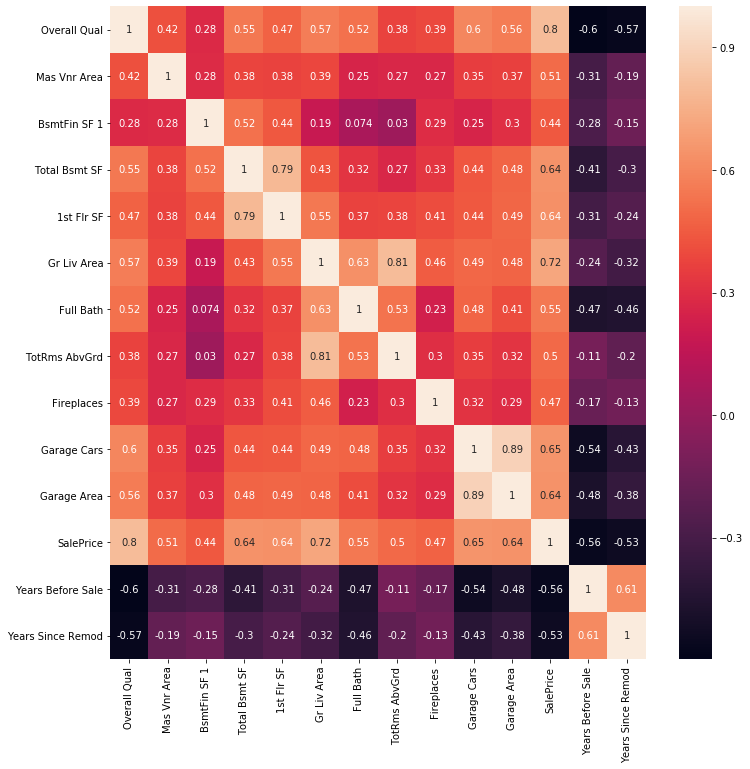

In [23]:
strong_corr = transform_df.select_dtypes(include=['integer', 'float']).corr()
fig = plt.figure(figsize=(12, 12))
ax = sns.heatmap(data=strong_corr, annot=True)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

The following pairs of columns have strong correlations:
* Garage area, Garage cars
* TotRms AbvGrd, Gr Liv Area

After looking at the documentation of the dataset, each pair of columns convey similar information. One column from each pair will be dropped. The Gr Liv Area and Garage Area columns will be kept as these are continuous variables.

In [24]:
transform_df = transform_df.drop(['TotRms AbvGrd', 'Garage Cars'], axis = 1)

### CATEGORICAL FEATURES

#### ORDINAL FEATURES

There are 6 ordinal columns remaining in the dataset. The text values in these columns will be converted to numeric values using a dictionary. A simple ranking system will be implemented.

In [25]:
ordinal_cols = ['Overall Qual', 'Overall Cond', 'Exter Qual', 'Exter Cond', 'Heating QC', 'Kitchen Qual']

for col in ordinal_cols:
    print(col,"\n", data[col].unique(), "\n")

Overall Qual 
 [ 6  5  7  8  9  4  3  2 10  1] 

Overall Cond 
 [5 6 7 2 8 4 9 3 1] 

Exter Qual 
 ['TA' 'Gd' 'Ex' 'Fa'] 

Exter Cond 
 ['TA' 'Gd' 'Fa' 'Po' 'Ex'] 

Heating QC 
 ['Fa' 'TA' 'Ex' 'Gd' 'Po'] 

Kitchen Qual 
 ['TA' 'Gd' 'Ex' 'Fa' 'Po'] 



The Overall Qual and Overall Cond columns are numeric and have a ranked values, so these do not need to be changed. The other four columns will be transformed into numeric columns.

In [26]:
exter_r = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
transform_df['Exter Qual'] = transform_df['Exter Qual'].map(exter_r)
transform_df['Exter Cond'] = transform_df['Exter Cond'].map(exter_r)
transform_df['Heating QC'] = transform_df['Heating QC'].map(exter_r)
transform_df['Kitchen Qual'] = transform_df['Kitchen Qual'].map(exter_r)

print(transform_df['Exter Qual'].unique())
print(transform_df['Exter Cond'].unique())
print(transform_df['Heating QC'].unique())
print(transform_df['Kitchen Qual'].unique())

[3 4 5 2]
[3 4 2 1 5]
[2 3 5 4 1]
[3 4 5 2 1]


#### NOMINAL FEATURES 

Below all the nominal columns have been selected. These will be coded and dummy columns will be added to the dataset.

In [27]:
nom_cols = ['MS Zoning', 'Street', 'Lot Shape', 
            'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 
            'Condition 1', 'Condition 2', 'House Style', 'Bldg Type', 
            'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
            'Foundation', 'Heating', 'Central Air', 'Functional', 'Paved Drive']

for col in nom_cols:
    u = data[col].unique()
    print(col,"\n", u, len(u), "\n")

MS Zoning 
 ['RL' 'RH' 'FV' 'RM' 'C (all)' 'I (all)' 'A (agr)'] 7 

Street 
 ['Pave' 'Grvl'] 2 

Lot Shape 
 ['IR1' 'Reg' 'IR2' 'IR3'] 4 

Land Contour 
 ['Lvl' 'HLS' 'Bnk' 'Low'] 4 

Utilities 
 ['AllPub' 'NoSewr' 'NoSeWa'] 3 

Lot Config 
 ['Corner' 'Inside' 'CulDSac' 'FR2' 'FR3'] 5 

Land Slope 
 ['Gtl' 'Mod' 'Sev'] 3 

Condition 1 
 ['Norm' 'Feedr' 'PosN' 'RRNe' 'RRAe' 'Artery' 'PosA' 'RRAn' 'RRNn'] 9 

Condition 2 
 ['Norm' 'Feedr' 'PosA' 'PosN' 'Artery' 'RRNn' 'RRAe' 'RRAn'] 8 

House Style 
 ['1Story' '2Story' '1.5Fin' 'SFoyer' 'SLvl' '2.5Unf' '1.5Unf' '2.5Fin'] 8 

Bldg Type 
 ['1Fam' 'TwnhsE' 'Twnhs' 'Duplex' '2fmCon'] 5 

Roof Style 
 ['Hip' 'Gable' 'Mansard' 'Gambrel' 'Shed' 'Flat'] 6 

Roof Matl 
 ['CompShg' 'WdShake' 'Tar&Grv' 'WdShngl' 'Membran' 'ClyTile' 'Roll'
 'Metal'] 8 

Exterior 1st 
 ['BrkFace' 'VinylSd' 'Wd Sdng' 'CemntBd' 'HdBoard' 'Plywood' 'MetalSd'
 'AsbShng' 'WdShing' 'Stucco' 'AsphShn' 'BrkComm' 'CBlock' 'PreCast'
 'Stone' 'ImStucc'] 16 

Exterior 2nd 
 ['Pl

The nominal columns will be transformed into dummy columns. Any columns with more than 10 unique values will be dropped as this will add too many dummy columns to the dataset.

In [28]:
drop_nom = []

for col in nom_cols:
    if len(transform_df[col].unique()) > 10:
        drop_nom.append(col)
        
drop_nom

['Exterior 1st', 'Exterior 2nd']

In [29]:
transform_df = transform_df.drop(drop_nom, axis=1)

Now all nominal columns will be transformed to categorical data type and dummy columns will be obtained.

In [30]:
nom_df = transform_df.select_dtypes(include=['object'])
nom_df.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Foundation,Heating,Central Air,Functional,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,CBlock,GasA,Y,Typ,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,CBlock,GasA,Y,Typ,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,CBlock,GasA,Y,Typ,Y
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,CBlock,GasA,Y,Typ,Y
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,PConc,GasA,Y,Typ,Y


In [31]:
nom_df = nom_df.astype('category')
nom_df.head()

,MS Zoning,Street,Lot Shape,Land Contour,Utilities,Lot Config,Land Slope,Neighborhood,Condition 1,Condition 2,Bldg Type,House Style,Roof Style,Roof Matl,Foundation,Heating,Central Air,Functional,Paved Drive
0,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,CBlock,GasA,Y,Typ,P
1,RH,Pave,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,Gable,CompShg,CBlock,GasA,Y,Typ,Y
2,RL,Pave,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,CBlock,GasA,Y,Typ,Y
3,RL,Pave,Reg,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,Hip,CompShg,CBlock,GasA,Y,Typ,Y
4,RL,Pave,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,Gable,CompShg,PConc,GasA,Y,Typ,Y


In [32]:
transform_df = pd.concat([transform_df, pd.get_dummies(nom_df)], axis=1).drop(nom_df.columns, axis=1)
transform_df.head()

,Overall Qual,Mas Vnr Area,Exter Qual,Exter Cond,BsmtFin SF 1,Total Bsmt SF,Heating QC,1st Flr SF,Gr Liv Area,Full Bath,...,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sal,Functional_Sev,Functional_Typ,Paved Drive_N,Paved Drive_P,Paved Drive_Y
0,6,112.0,3,3,639.0,1080.0,2,1656,1656,1,...,0,0,0,0,0,0,1,0,1,0
1,5,0.0,3,3,468.0,882.0,3,896,896,1,...,0,0,0,0,0,0,1,0,0,1
2,6,108.0,3,3,923.0,1329.0,3,1329,1329,1,...,0,0,0,0,0,0,1,0,0,1
3,7,0.0,4,3,1065.0,2110.0,5,2110,2110,2,...,0,0,0,0,0,0,1,0,0,1
4,5,0.0,3,3,791.0,928.0,4,928,1629,2,...,0,0,0,0,0,0,1,0,0,1


### UPDATE SELECT FEATURES

In [33]:
def transform_features(df):
    
    # missing values
    data_missing = df.isnull().sum()
    drop = data_missing[data_missing > ames.shape[0] / 20].index
    data = ames.drop(drop, axis = 1)
    
    text_drop = data.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    t_cols = text_drop[text_drop > 0].index
    data = data.drop(t_cols, axis=1)
    
    numeric_missing = data.select_dtypes(include=['integer', 'float']).isnull().sum().sort_values(ascending=False)
    num_col = list(numeric_missing[numeric_missing > 0].index)
    replace = {}
    for col in num_col:
        replace[col] = data[col].mode()[0]
    data = data.fillna(replace)
    
    # creating new features
    years_before_sale = data['Yr Sold'] - data['Year Built']
    years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    data['Years Before Sale'] = years_before_sale
    data['Years Since Remod'] = years_since_remod
    data = data.drop([1702, 2180, 2181], axis=0)
    data = data.drop(['Year Built', 'Year Remod/Add'], axis = 1)
    
    # data leakage
    data = data.drop(['Yr Sold', 'Mo Sold', 'Sale Type', 'Sale Condition'], axis = 1)
    data = data.drop(['PID', 'Order'], axis=1)
    
    return data

def select_features(df):
    
    # correlation
    numeric_corr = df.select_dtypes(include=['integer', 'float']).corr()
    target_corr = numeric_corr["SalePrice"].abs().sort_values(ascending=False)
    df = df.drop(target_corr[target_corr < 0.4].index, axis = 1)
    df = df.drop(['TotRms AbvGrd', 'Garage Cars'], axis = 1)
    
    # categorical
    exter_r = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
    df['Exter Qual'] = df['Exter Qual'].map(exter_r)
    df['Exter Cond'] = df['Exter Cond'].map(exter_r)
    df['Heating QC'] = df['Heating QC'].map(exter_r)
    df['Kitchen Qual'] = df['Kitchen Qual'].map(exter_r)
    
    nom_cols = ['MS Zoning', 'Street', 'Lot Shape', 
            'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 
            'Condition 1', 'Condition 2', 'House Style', 'Bldg Type', 
            'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
            'Foundation', 'Heating', 'Central Air', 'Functional', 'Paved Drive']
    
    drop_nom = []

    for col in nom_cols:
        if len(df[col].unique()) > 10:
            drop_nom.append(col)
            
    df = df.drop(drop_nom, axis=1)
    nom_df = df.select_dtypes(include=['object'])
    nom_df = nom_df.astype('category')
    df = pd.concat([df, pd.get_dummies(nom_df)], axis=1).drop(nom_df.columns, axis=1)
    
    return df

def train_and_test(df):
    
    # split the dataset into a train and test datasets
    train = df.iloc[0:1460, :]
    test = df.iloc[1460:, :]
    
    # get datasets from train and test containing only numeric columns
    numeric_train = train.select_dtypes(include=['integer', 'float'])
    numeric_test = test.select_dtypes(include=['integer', 'float'])
    
    # get list of all the column names that will be used as features
    features = numeric_train.columns.drop('SalePrice')
    
    linear = LinearRegression()
    linear.fit(X = train[features], y = train['SalePrice'])
    predictions = linear.predict(test[features])
    mse = mean_squared_error(test['SalePrice'], predictions)
    rmse = np.sqrt(mse)
    
    return rmse

In [34]:
transform_df = transform_features(ames)
select_df = select_features(transform_df)
rmse = train_and_test(select_df)
rmse

32302.027990371607

After selecting the right features and handling categorical variables, the rmse of the model has decreased from \\$55275.37 to \\$32302.03.

This iteration of the model has used all columns available after cleaning and preparation and thus has resulted in a significant decrease in rmse value compared to the decrease between the first two iterations of the model.

## K-FOLD CROSS VALIDATION

The train_and_test function will be modified to allow different test and train sample sizes and the option of performing K-Fold cross validation on a desried number of folds.

The validation method used will be specifed by the k parameter of the function.

* If k = 0, simple holdout validation will be used as with the first three iterations of the model.
* If k = 1, simple cross validation will be used with the training and test sets.
* If k > 1, K-Fold cross validation will be used with k folds.

In [50]:
def transform_features(df):
    
    # missing values
    data_missing = df.isnull().sum()
    drop = data_missing[data_missing > ames.shape[0] / 20].index
    data = ames.drop(drop, axis = 1)
    
    text_drop = data.select_dtypes(include=['object']).isnull().sum().sort_values(ascending=False)
    t_cols = text_drop[text_drop > 0].index
    data = data.drop(t_cols, axis=1)
    
    numeric_missing = data.select_dtypes(include=['integer', 'float']).isnull().sum().sort_values(ascending=False)
    num_col = list(numeric_missing[numeric_missing > 0].index)
    replace = {}
    for col in num_col:
        replace[col] = data[col].mode()[0]
    data = data.fillna(replace)
    
    # creating new features
    years_before_sale = data['Yr Sold'] - data['Year Built']
    years_since_remod = data['Yr Sold'] - data['Year Remod/Add']
    data['Years Before Sale'] = years_before_sale
    data['Years Since Remod'] = years_since_remod
    data = data.drop([1702, 2180, 2181], axis=0)
    data = data.drop(['Year Built', 'Year Remod/Add'], axis = 1)
    
    # data leakage
    data = data.drop(['Yr Sold', 'Mo Sold', 'Sale Type', 'Sale Condition'], axis = 1)
    data = data.drop(['PID', 'Order'], axis=1)
    
    return data

def select_features(df):
    
    # correlation
    numeric_corr = df.select_dtypes(include=['integer', 'float']).corr()
    target_corr = numeric_corr["SalePrice"].abs().sort_values(ascending=False)
    df = df.drop(target_corr[target_corr < 0.4].index, axis = 1)
    df = df.drop(['TotRms AbvGrd', 'Garage Cars'], axis = 1)
    
    # categorical
    exter_r = {'Ex': 5, 'Gd': 4, 'TA': 3, 'Fa': 2, 'Po': 1}
    df['Exter Qual'] = df['Exter Qual'].map(exter_r)
    df['Exter Cond'] = df['Exter Cond'].map(exter_r)
    df['Heating QC'] = df['Heating QC'].map(exter_r)
    df['Kitchen Qual'] = df['Kitchen Qual'].map(exter_r)
    
    nom_cols = ['MS Zoning', 'Street', 'Lot Shape', 
            'Land Contour', 'Utilities', 'Lot Config', 'Land Slope', 
            'Condition 1', 'Condition 2', 'House Style', 'Bldg Type', 
            'Roof Style', 'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
            'Foundation', 'Heating', 'Central Air', 'Functional', 'Paved Drive']
    
    drop_nom = []

    for col in nom_cols:
        if len(df[col].unique()) > 10:
            drop_nom.append(col)
            
    df = df.drop(drop_nom, axis=1)
    nom_df = df.select_dtypes(include=['object'])
    nom_df = nom_df.astype('category')
    df = pd.concat([df, pd.get_dummies(nom_df)], axis=1).drop(nom_df.columns, axis=1)
    
    return df

def train_and_test(df, k):
    
    # get features 
    numeric_cols = df.select_dtypes(include=['integer', 'float'])
    features = numeric_cols.columns.drop('SalePrice')
    
    # create linear regression model
    linear = LinearRegression()
    
    # holdout validation
    if k == 0:
    
        # split the dataset into a train and test datasets
        train = df.iloc[0:1460, :]
        test = df.iloc[1460:, :]
        
        # train and test model
        linear.fit(X = train[features], y = train['SalePrice'])
        predictions = linear.predict(test[features])
        mse = mean_squared_error(test['SalePrice'], predictions)
        rmse = np.sqrt(mse)
        
        return rmse
    
    # simple cross validation
    elif k == 1:
        
        # suffle dataframe rows
        shuffled_indexes = np.random.permutation(df.shape[0])
        shuf_df = df.iloc[shuffled_indexes, :]
        
        # split dataframe into two parts
        fold_one = shuf_df.iloc[:1460, :]
        fold_two = shuf_df.iloc[1460:, :]
        
        # train on fold_one, test on fold_two
        linear.fit(X = fold_one[features], y = fold_one['SalePrice'])
        predictions = linear.predict(fold_two[features])
        mse_1 = mean_squared_error(fold_two['SalePrice'], predictions)
        rmse_1 = np.sqrt(mse_1)
        
        # train on fold_two, test on fold_one
        linear.fit(X = fold_two[features], y = fold_two['SalePrice'])
        predictions = linear.predict(fold_one[features])
        mse_2 = mean_squared_error(fold_one['SalePrice'], predictions)
        rmse_2 = np.sqrt(mse_2)
        
        avg_rmse = np.mean([rmse_1, rmse_2])
        
        return avg_rmse
    
    # K-Fold Cross Validation
    else:
      
        kf = KFold(n_splits = k, shuffle = True)
        mses = cross_val_score(estimator = linear, X = df[features], y = df[['SalePrice']], 
                               scoring = 'neg_mean_squared_error', cv = kf)
        
        rmses = np.sqrt(np.absolute(mses))
        avg_rmse = np.mean(rmses)
        
        return avg_rmse

Testing simple holdout validation returns the same rmse as the third iteration which is correct.

In [51]:
transform_df = transform_features(ames)
filter_df = select_features(transform_df)
rmse = train_and_test(filter_df, 0)
rmse

32302.027990371607

Simple Cross Validation rmse:

In [52]:
transform_df = transform_features(ames)
filter_df = select_features(transform_df)
rmse = train_and_test(filter_df, 1)
rmse

28726.692003045275

Below a function is created to run the model with a k value from 0 to a value specified and plot the resulting rmses.

In [86]:
def k_rmse(dataset, max_folds):
    y = []
    x = [i for i in range(max_folds+1)]
    for k in range(max_folds + 1):
        transform_df = transform_features(dataset)
        filter_df = select_features(transform_df)
        rmse = train_and_test(filter_df, k)
        y.append(rmse)
    
    plt.figure(figsize=(10, 10))
    plt.ylim(25000, 35000)
    plt.plot(x, y, marker="o")
    plt.title("k vs AVG RMSE")
    plt.xlabel("k")
    plt.ylabel("Average RMSE")
    plt.annotate("Simple Cross Validation RMSE", xytext = (1.5, 32500), xy=(0.3, 32302.028), arrowprops={'facecolor':'red'})
    plt.annotate("Simple Holdout RMSE", xytext = (5, 28726.69), xy=(1.2, 28728), arrowprops={'facecolor':'red'})
    plt.show()

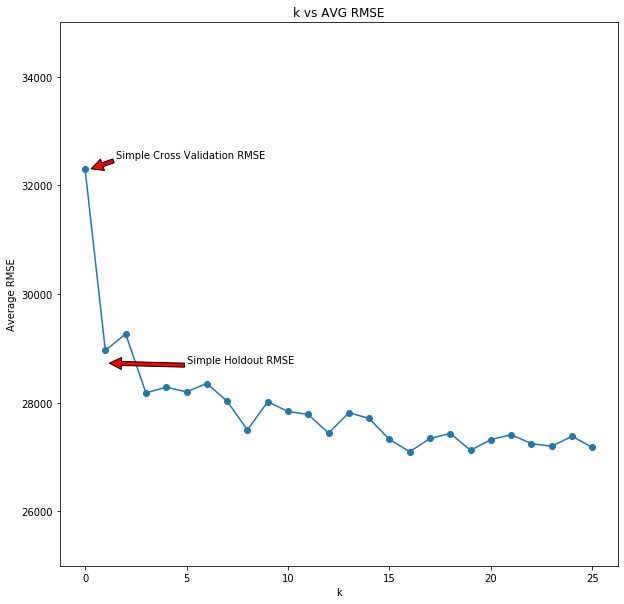

In [87]:
k_rmse(ames, 25)

The graph above shows the rmse for different number of folds, the genral trend shows as the number of folds increase the average rmse for each fold decreases.